In [3]:
import pandas as pd
from rdflib import Graph, URIRef, Literal, RDF, RDFS, Namespace
from urllib.parse import quote
from rdflib.plugins.sparql import prepareQuery
import time

## Cargar excel al grafo

In [22]:
dfcert = pd.read_excel('tramites/certificadosnormsinespaciocertlisto.xlsx')
dfdoc = pd.read_excel('tramites/certificadosnormsinespaciodoclisto.xlsx')

In [23]:
# Crear el grafo y el espacio de nombres
g = Graph()
ex = Namespace("http://example.org/")
# Diccionario para realizar un seguimiento de las instituciones
Ministerios = {}
Ministerios_uri = {}
Tramitesdic = {}
# Iterar sobre el DataFrame y agregar ministerio, instituciones y tramites con documentos
for _, row in dfcert.iterrows():
    tramite_nombre = row['Nombre del trámite']
    tramite_uri = Tramitesdic.get(tramite_nombre)
    if not tramite_uri:
        Ministerio_nombre = row['Ministerio']
        Ministerio_uri = Ministerios_uri.get(Ministerio_nombre)
        # Si el ministerio no existe en el diccionario, crear el nodo
        if not Ministerio_uri:
            Ministerio_uri = ex[quote(Ministerio_nombre.replace(" ", "_"))]
            g.add((Ministerio_uri, RDF.type, ex.Ministerio))
            Ministerios_uri[Ministerio_nombre] = Ministerio_uri
            Ministerios[Ministerio_nombre]={}
        institucion_nombre = row['Institución']
        institucion_uri = Ministerios[Ministerio_nombre].get(institucion_nombre)
        # Si la institución no existe en el diccionario, crear el nodo
        if not institucion_uri:
            institucion_uri = ex[quote(institucion_nombre.replace(" ", "_"))]
            g.add((institucion_uri, RDF.type, ex.Institucion))
            g.add((Ministerio_uri, ex.tieneInstitucion, institucion_uri))
            Ministerios[Ministerio_nombre][institucion_nombre] = institucion_uri        
        # Crear el nodo para el tramite y conectarlo a la institución
        tramite_nombre = row['Nombre del trámite']
        tramite_uri = ex[quote(tramite_nombre.replace(" ", "_"))]
        g.add((tramite_uri, RDF.type, ex.Tramite))
        g.add((institucion_uri, ex.realizaTramite, tramite_uri))
        Tramitesdic[tramite_nombre]=tramite_uri
    if row['¿Requiere de algún certificado?'] == 'Sí':
        # Crear nodos para cada documento y conectarlos al tramite
        certificado_nombre = row['Detalle certificados']
        certificado_uri = ex[quote(certificado_nombre.replace(" ", "_"))]
        g.add((certificado_uri, RDF.type, ex.certificado))
        g.add((tramite_uri, ex.requiereCertificado, certificado_uri))
    
#-------------------------Requerimientos-----------------
#-------Documentos notariales
    # Verificar si el tramite requiere documento
for _, row in dfdoc.iterrows():
    tramite_nombre = row['Nombre del trámite']
    tramite_uri = Tramitesdic.get(tramite_nombre)
    if row['¿Requiere de un documento notarial?'] == 'Sí':
        documento_nombre = row['Detalle documentos']
        documento_uri = ex[quote(documento_nombre.replace(" ","_"))]
        g.add((documento_uri, RDF.type, ex.Documento))
        g.add((tramite_uri, ex.requiereDocumento, documento_uri))

# Consultas

### tramites en cierto ministerio

In [24]:
#Esta función entrega todos los tramites en un cierto ministerio
def consultar_tramites_en_ministerio(graf,ministerioo):
    query_instituciones_salud = """
        PREFIX ex: <http://example.org/>
        SELECT ?tramite
        WHERE {
            ?ministerio rdf:type ex:Ministerio.
            ?ministerio ex:tieneInstitucion ?institucion.
            ?institucion rdf:type ex:Institucion.
            ?institucion ex:realizaTramite ?tramite.
            FILTER (?ministerio = ex:ministerioo)
        }
    """
    start_time = time.time()


    
    # Preparar la consulta
    query_instituciones_salud = prepareQuery(query_instituciones_salud, initNs={"rdf": RDF, "ex": ex})
    # Ejecutar la consulta en el grafo RDF
    result_instituciones_salud = graf.query(query_instituciones_salud)
    # Imprimir los resultados
#    print("Instituciones asociadas al Ministerio de Salud:")
#    for row in result_instituciones_salud:
#        print(row.tramite)
    end_time = time.time()

    elapsed_time = end_time - start_time
    return [result_instituciones_salud,elapsed_time]

In [30]:
for j in consultar_tramites_en_ministerio(g,'Ministerio_Secretaria_General_de_Gobierno')[0]:
    print(j.tramite)

http://example.org/Sistema_Integrado_de_Atenci%C3%B3n_Ciudadana_%28SIAC%29_del_Consejo_Nacional_de_Televisi%C3%B3n_%28CNTV%29.
http://example.org/Recepci%C3%B3n_de_denuncias_sobre_programas_exhibidos_en_televisi%C3%B3n
http://example.org/Fondo_CNTV
http://example.org/Postulaci%C3%B3n_a_Concesiones_de_Televisi%C3%B3n_Digital_de_Libre_Recepci%C3%B3n
http://example.org/Sistema_Integral_de_Atenci%C3%B3n_Ciudadana
http://example.org/Postulaci%C3%B3n_al_fondo_de_fortalecimiento_de_las_organizaciones_de_inter%C3%A9s_p%C3%BAblico
http://example.org/Postulaci%C3%B3n_al_fondo_al_fomento_de_medios_de_comunicaci%C3%B3n
http://example.org/Solicitud_de_Inscripci%C3%B3n_al_Catastro_de_Organizaciones_de_Inter%C3%A9s_P%C3%BAblico
http://example.org/Solicitud_de_Certificado_de_Organizaci%C3%B3n_Comunitaria


### Ministerios

In [5]:
def consultar_ministerios(graf):
    query_instituciones_salud = """
        SELECT DISTINCT ?ministerio
        WHERE {
            ?ministerio rdf:type ex:Ministerio ;
        }
    """
    start_time = time.time()
    # Preparar la consulta
    query_instituciones_salud = prepareQuery(query_instituciones_salud, initNs={"rdf": RDF, "ex": ex})
    # Ejecutar la consulta en el grafo RDF
    result_instituciones_salud = graf.query(query_instituciones_salud)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return [result_instituciones_salud, elapsed_time]
    # Imprimir los resultados
#    print("Instituciones asociadas al Ministerio de Salud:")
  #  for row in result_instituciones_salud:
 #       print(row.ministerio)

Instituciones asociadas al Ministerio de Salud:
http://example.org/Ministerio_de_Transportes_y_Telecomunicaciones
http://example.org/Ministerio_de_Hacienda
http://example.org/Ministerio_de_las_Culturas%2C_las_Artes_y_el_Patrimonio
http://example.org/Consejo_de_Defensa_del_Estado
http://example.org/Ministerio_de_Desarrollo_Social_y_Familia
http://example.org/Ministerio_de_Agricultura
http://example.org/Ministerio_de_Econom%C3%ADa%2C_Fomento_y_Turismo
http://example.org/Ministerio_de_Defensa_Nacional
http://example.org/Ministerio_de_Obras_P%C3%BAblicas
http://example.org/Ministerio_del_Trabajo_y_Previsi%C3%B3n_Social
http://example.org/Ministerio_de_Justicia_y_Derechos_Humanos
http://example.org/Ministerio_de_Relaciones_Exteriores
http://example.org/Ministerio_del_Deporte
http://example.org/Ministerio_de_Salud
http://example.org/Ministerio_de_Educaci%C3%B3n
http://example.org/Ministerio_de_Energ%C3%ADa
http://example.org/Ministerio_del_Medio_Ambiente
http://example.org/Ministerio_de_Mine

### Instituciones asociadas a algún ministerio

In [118]:
def instituciones_asoc_a_ministerio(graf):
    query_instituciones_salud = """
        SELECT DISTINCT ?institucion
        WHERE {
            ?ministerio rdf:type ex:Ministerio ;
                        ex:tieneInstitucion ?institucion .
            ?institucion rdf:type ex:Institucion .
            FILTER (?ministerio = ex:Ministerio_de_Hacienda)
        }
    """
    start_time = time.time()
    # Preparar la consulta
    query_instituciones_salud = prepareQuery(query_instituciones_salud, initNs={"rdf": RDF, "ex": ex})
    # Ejecutar la consulta en el grafo RDF
    result_instituciones_salud = graf.query(query_instituciones_salud)
    end_time = time.time()

    elapsed_time = end_time - start_time
    
    return [result_instituciones_salud, elapsed_time]
    # Imprimir los resultados
#    print("Instituciones asociadas al Ministerio de Hacienda:")
#    for row in result_instituciones_salud:
#        print(row.institucion) 

### Contar instuciones por ministerio

In [70]:
from rdflib import Graph, Namespace, RDF, URIRef, Literal
from urllib.parse import quote
# Consulta SPARQL para contar instituciones por ministerio
query_contar_instituciones_por_ministerio = """
    PREFIX ex: <http://example.org/>

    SELECT ?ministerio (COUNT( ?institucion) AS ?count)
    WHERE {
        ?ministerio rdf:type ex:Ministerio.
        ?ministerio ex:tieneInstitucion ?institucion.
    }
    GROUP BY ?ministerio
"""
# Ejecutar la consulta en el grafo RDF
result_contar_instituciones_por_ministerio = g.query(query_contar_instituciones_por_ministerio)

# Imprimir los resultados
print("Número de instituciones por ministerio:")
for row in result_contar_instituciones_por_ministerio:
    ministerio = row["ministerio"]
    cantidad_instituciones = row["count"]
    print(f"{ministerio}: {cantidad_instituciones}")

Número de instituciones por ministerio:


### Contar tramites por ministerio

In [8]:
from rdflib import Graph, Namespace, RDF, URIRef, Literal
from urllib.parse import quote

# Consulta SPARQL para contar instituciones por ministerio
query_contar_instituciones_por_ministerio = """
    PREFIX ex: <http://example.org/>

    SELECT ?ministerio (COUNT( ?tramite) AS ?count)
    WHERE {
        ?ministerio rdf:type ex:Ministerio.
        ?ministerio ex:tieneInstitucion ?institucion.
        ?institucion rdf:type ex:Institucion.
        ?institucion ex:realizaTramite ?tramite.
      
    }
    GROUP BY ?ministerio
"""
# Ejecutar la consulta en el grafo RDF
result_contar_instituciones_por_ministerio = g.query(query_contar_instituciones_por_ministerio)

# Imprimir los resultados
print("Número de tramites por ministerio:")
for row in result_contar_instituciones_por_ministerio:
    ministerio = row["ministerio"]
    cantidad_instituciones = row["count"]
    print(f"{ministerio}: {cantidad_instituciones}")

Número de tramites por ministerio:
http://example.org/Ministerio_de_Transportes_y_Telecomunicaciones: 175
http://example.org/Ministerio_de_Hacienda: 426
http://example.org/Ministerio_de_las_Culturas%2C_las_Artes_y_el_Patrimonio: 156
http://example.org/Consejo_de_Defensa_del_Estado: 4
http://example.org/Ministerio_de_Desarrollo_Social_y_Familia: 111
http://example.org/Ministerio_de_Agricultura: 176
http://example.org/Ministerio_de_Econom%C3%ADa%2C_Fomento_y_Turismo: 324
http://example.org/Ministerio_de_Defensa_Nacional: 374
http://example.org/Ministerio_de_Obras_P%C3%BAblicas: 84
http://example.org/Ministerio_del_Trabajo_y_Previsi%C3%B3n_Social: 239
http://example.org/Ministerio_de_Justicia_y_Derechos_Humanos: 158
http://example.org/Ministerio_de_Relaciones_Exteriores: 47
http://example.org/Ministerio_del_Deporte: 19
http://example.org/Ministerio_de_Salud: 525
http://example.org/Ministerio_de_Educaci%C3%B3n: 146
http://example.org/Ministerio_de_Energ%C3%ADa: 86
http://example.org/Minist

### Requisitos por ministerio

In [120]:
from rdflib import Graph, Literal, URIRef
from rdflib.namespace import RDF, XSD
def contar_requisitos_por_ministerio(graf):
    # Ejecutar la consulta SPARQL
    query = """
    PREFIX ex: <http://example.org/>
    SELECT ?ministerio (COUNT(DISTINCT ?documento) AS ?countDocumentos) (COUNT(DISTINCT?certificado) AS ?countCertificados) (COUNT(DISTINCT ?documento) + COUNT(DISTINCT ?certificado) AS ?suma)
    WHERE {
        ?ministerio rdf:type ex:Ministerio.
        ?ministerio ex:tieneInstitucion ?institucion.
        ?institucion rdf:type ex:Institucion.
        ?institucion ex:realizaTramite ?tramite.
        OPTIONAL {
            ?tramite ex:requiereDocumento ?documento.
        }
        OPTIONAL {
            ?tramite ex:requiereCertificado ?certificado.
        }
    }
    GROUP BY ?ministerio
    ORDER BY DESC(?suma)
    """
    start_time = time.time()
    result = graf.query(query)
    
    # Imprimir resultados
    #for row in result:
        #ministerio, count_documentos, count_certificados, suma = row
        #print(f"Ministerio: {ministerio}, Certificados: {count_certificados},Documentos: {count_documentos}, Suma: {suma}")
    end_time = time.time()
    elapsed_time = end_time - start_time
    #print("Tiempo de ejecución:", elapsed_time, "segundos")
    return [result,elapsed_time]

### Requisitos asociados a un ministerio

In [78]:
def requisitos_asoc_a_ministerio(graf):
    query_instituciones_salud = """
        SELECT DISTINCT ?documento
        WHERE {
            ?ministerio rdf:type ex:Ministerio.
            ?ministerio ex:tieneInstitucion ?institucion .
            ?institucion rdf:type ex:Institucion .
            ?institucion ex:realizaTramite ?tramite.
            ?tramite ex:requiereDocumento ?documento.

            FILTER (?ministerio = ex:Ministerio_de_Econom%C3%ADa%2C_Fomento_y_Turismo)
        }
    """
    # Preparar la consulta
    start_time = time.time()


    query_instituciones_salud = prepareQuery(query_instituciones_salud, initNs={"rdf": RDF, "ex": ex})

    # Ejecutar la consulta en el grafo RDF
    result_instituciones_salud = graf.query(query_instituciones_salud)
    end_time = time.time()

    elapsed_time = end_time - start_time
    return [result_instituciones_salud, elapsed_time]
    # Imprimir los resultados
    #print("requisitos asociadas al Ministerio de Hacienda:")
    #j=0
    #for row in result_instituciones_salud:
     #   j+=1    
      #  print(row.documento)
    #print(j)

requisitos asociadas al Ministerio de Hacienda:
http://example.org/Autorizaci%C3%B3n_notarial_de_uso_de_infraestructura
http://example.org/Mandato
http://example.org/autorizaci%C3%B3n_notarial_de_representante_legal
http://example.org/declaraci%C3%B3n_jurada_de_la_duraci%C3%B3n_de_la_sociedad
http://example.org/Fotocopia_notarial_de_los_estatutos_de_la_organizaci%C3%B3n_y_sus_modificaciones
http://example.org/Si_el_certificado_de_vigencia_no_establece_la_directiva%2C_se_deber%C3%A1_complementar_con_una_declaraci%C3%B3n_notarial_la_directiva%2C_por_el_presidente_o_representante_legal_de_la_organizaci%C3%B3n.
http://example.org/poder_de_acreditaci%C3%B3n_de_representaci%C3%B3n_legal_vigente%2C_en_caso_de_personas_jur%C3%ADdicas
http://example.org/declaraci%C3%B3n_jurada_de_residencia
http://example.org/Declaraci%C3%B3n_jurada_de_origen_y
http://example.org/o_informes_de_toxinas_emitidos_por_el_Servicio_de_Salud%2C_seg%C3%BAn_corresponda.
http://example.org/Autorizaci%C3%B3n_notarial_en_c

### Número de requisitos distintos

In [29]:
def requisitos_distintos(graf)
    ex = Namespace("http://example.org/")
    # Definir la consulta SPARQL
    query = prepareQuery("""
        PREFIX ex: <http://example.org/>

        SELECT (COUNT(DISTINCT ?documento) AS ?numDocumentos) (COUNT(DISTINCT ?certificado) AS ?numCertificados)
        WHERE {
          ?tramite rdf:type ex:Tramite.
          OPTIONAL { ?tramite ex:requiereDocumento ?documento. }
          OPTIONAL { ?tramite ex:requiereCertificado ?certificado. }
        }
    """, initNs={"ex": ex})
    start_time = time.time()

    # Ejecutar la consulta y obtener los resultados
    resultados = g.query(query)
    return(resultados)
    # Detener temporizador y calcular tiempo transcurrido
    end_time = time.time()

    elapsed_time = end_time - start_time
    return[resultados,elapsed_time]

    # Mostrar los resultados
#    for resultado in resultados:
 #       num_documentos = resultado[0]
  #      num_certificados = resultado[1]
   #     print("Número de documentos distintos:", num_documentos)
    #    print("Número de certificados distintos:", num_certificados)
    #print("Tiempo de ejecución:", elapsed_time, "segundos")

Número de documentos distintos: 365
Número de certificados distintos: 93
1
Tiempo de ejecución: 0.0 segundos


## requisitos asociados a cierto tramite

In [129]:
def requisitos_asoc_a_tramite(graf)
    query_instituciones_salud = """
        SELECT DISTINCT ?documento
        WHERE {
            ?ministerio rdf:type ex:Ministerio.
            ?ministerio ex:tieneInstitucion ?institucion .
            ?institucion rdf:type ex:Institucion .
            ?institucion ex:realizaTramite ?tramite.
            ?tramite ex:requiereDocumento ?documento.

            FILTER (?tramite = ex:Postulaci%C3%B3n_al_fondo_al_fomento_de_medios_de_comunicaci%C3%B3n)
        }
    """
    start_time = time.time()
    # Preparar la consulta
    query_instituciones_salud = prepareQuery(query_instituciones_salud, initNs={"rdf": RDF, "ex": ex})
    # Ejecutar la consulta en el grafo RDF
    result_instituciones_salud = graf.query(query_instituciones_salud)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return[result_instituciones_salud,elapsed_time]
# Imprimir los resultados
#    print("requisitos asociadas al Ministerio de Hacienda:")
 #   j=0
  #  for row in result_instituciones_salud:
   #     j+=1    
    #    print(row.documento)
    #print(j)

requisitos asociadas al Ministerio de Hacienda:
http://example.org/Garant%C3%ADa_Notarial_%28letra_de_cambio%2C_pagar%C3%A9%29
1


# ----------------------
# Modificaciones al grafo
# ----------------------

### Consultar si se agregó el nuevo nodo

In [93]:
ex = Namespace("http://example.org/")

# Definir la consulta SPARQL para obtener la información de una institución específica
query = prepareQuery("""
    PREFIX ex: <http://example.org/>

    SELECT ?institucion ?tramite
    WHERE {
        ?institucion rdf:type ex:Institucion .
        ?institucion ex:tieneNuevoNodo ?tramite .
        FILTER(?institucion = ex:Servicio_Nacional_de_Aduanas)  # Filtrar por la institución específica
    }
""", initNs={"ex": ex})

# Ejecutar la consulta
results = g.query(query)

# Imprimir los resultados
for row in results:
    print(row)

## Agregar un nuevo nodo a cada institucion

In [115]:
from rdflib import Graph, Namespace, URIRef
from rdflib.namespace import RDF
def agregar_nodo(grafo,destino):
    start_time = time.time()
    # Definir el prefijo y el espacio de nombres
    # Definir la consulta SPARQL para seleccionar todos los sujetos de un cierto tipo
    query = """
        PREFIX ex: <http://example.org/>
        SELECT ?institucion
        WHERE {
            ?institucion rdf:type ex:destino.
        }
    """
    # Ejecutar la consulta SPARQL
    result = g.query(query)
    #for row in result:
     #   print(row)
    # Recorrer los resultados y agregar un nuevo nodo a cada uno
    for row in result:
        # Obtener el sujeto de la fila
        sujeto = row[0]

        # Agregar el nuevo nodo al sujeto
        nuevo_nodo = URIRef("http://example.org/NuevoNodo")
        g.add((sujeto, ex.tieneNuevoNodo, ex.nuevo_nodo))
        g.add((ex.nuevo_nodo, RDF.type, ex.newnodo))
    end_time = time.time()
    elapsed_time = end_time - start_time
   return elapsed_time

Tiempo de ejecución: 0.004982948303222656 segundos
(rdflib.term.URIRef('http://example.org/Subsecretar%C3%ADa_de_Transportes'),)
(rdflib.term.URIRef('http://example.org/Servicio_Nacional_de_Aduanas'),)
(rdflib.term.URIRef('http://example.org/Subsecretar%C3%ADa_de_las_Culturas_y_las_Artes'),)
(rdflib.term.URIRef('http://example.org/Consejo_de_Defensa_del_Estado'),)
(rdflib.term.URIRef('http://example.org/Direcci%C3%B3n_de_Compras_y_Contrataci%C3%B3n_P%C3%BAblica'),)
(rdflib.term.URIRef('http://example.org/Corporaci%C3%B3n_Nacional_de_Desarrollo_Ind%C3%ADgena'),)
(rdflib.term.URIRef('http://example.org/Corporaci%C3%B3n_Nacional_Forestal_y_de_Protecci%C3%B3n_de_Recursos_Naturales_Renovables'),)
(rdflib.term.URIRef('http://example.org/Corporaci%C3%B3n_de_Fomento_de_la_Producci%C3%B3n'),)
(rdflib.term.URIRef('http://example.org/Direcci%C3%B3n_General_de_Aeron%C3%A1utica_Civil'),)
(rdflib.term.URIRef('http://example.org/Direcci%C3%B3n_General_de_Obras_P%C3%BAblicas'),)
(rdflib.term.URIRef('h

### eliminar nuevo nodo en institución

In [92]:
#V2
# Importar la librería time
import time

# Marcar el tiempo de inicio
start_time = time.time()

# Definir la consulta SPARQL para seleccionar los nodos adicionales
query = """
    PREFIX ex: <http://example.org/>
    SELECT ?nuevo_nodo
    WHERE {
        ?nuevo_nodo rdf:type ex:newnodo.
    }
"""

# Ejecutar la consulta SPARQL
result = g.query(query)

# Recorrer los resultados y eliminar los nodos adicionales
for row in result:
    g.remove((row[0], None, None))  # Eliminar todas las tripletas con el nodo como sujeto
    g.remove((None, None, row[0]))  # Eliminar todas las tripletas con el nodo como objeto

# Marcar el tiempo de finalización y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print("Tiempo de ejecución:", elapsed_time, "segundos")


Tiempo de ejecución: 0.0040130615234375 segundos


## Agregar nuevo nodo a cada tramite

In [125]:
start_time = time.time()
# Definir el prefijo y el espacio de nombres
# Definir la consulta SPARQL para seleccionar todos los sujetos de un cierto tipo
query = """
    PREFIX ex: <http://example.org/>
    SELECT ?tramite
    WHERE {
        ?tramite rdf:type ex:Tramite.
    }
"""
# Ejecutar la consulta SPARQL
resulttramite = g.query(query)
end_time = time.time()

elapsed_time = end_time - start_time
print("Tiempo de ejecución:", elapsed_time, "segundos")
start_time = time.time()

# Recorrer los resultados y agregar un nuevo nodo a cada uno
for row in resulttramite:
    # Obtener el sujeto de la fila
    sujeto = row[0]
    
    # Agregar el nuevo nodo al sujeto
    nuevo_nodo = URIRef("http://example.org/NuevoNodo")
    g.add((sujeto, ex.requiereDocumento, nuevo_nodo))
    g.add((nuevo_nodo, RDF.type, ex.Documento))
end_time = time.time()
elapsed_time = end_time - start_time
print("Tiempo de ejecución:", elapsed_time, "segundos")

Tiempo de ejecución: 0.004987478256225586 segundos


### eliminar nuevo nodo en tramite

In [128]:
#V2
# Importar la librería time
import time
nuevo_nodo = URIRef("http://example.org/NuevoNodo")

# Marcar el tiempo de inicio
start_time = time.time()

# Definir la consulta SPARQL para seleccionar los nodos adicionales
query = """
    PREFIX ex: <http://example.org/>
    SELECT ?nuevonodo
    WHERE {
        ?nuevonodo rdf:type ex:Documento .
        FILTER(?nuevonodo = ex:NuevoNodo)
    }
"""

# Ejecutar la consulta SPARQL
result = g.query(query)

# Recorrer los resultados y eliminar los nodos adicionales
for row in result:
    g.remove((row[0], None, None))  # Eliminar todas las tripletas con el nodo como sujeto
    g.remove((None, None, row[0]))  # Eliminar todas las tripletas con el nodo como objeto

# Marcar el tiempo de finalización y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print("Tiempo de ejecución:", elapsed_time, "segundos")


Tiempo de ejecución: 0.04744315147399902 segundos


# ---------------------------------
# Constructor de grafos
# ---------------------------------


In [4]:
ex = Namespace("http://example.org/")    
def constructor_grafo(ministerios,instituciones,tramites,requisitos):
    graph1 = Graph()
    ex = Namespace("http://example.org/")    
    for j in range (0,ministerios):
        graph1.add((ex[f"A{j}"], RDF.type, ex.Ministerio))
        for i in range(0,instituciones):
            graph1.add((ex[f"A{j}"], ex.tieneInstitucion,ex[f"B{i}"]))
            graph1.add((ex[f"B{i}"], RDF.type, ex.Institucion))
            for k in range(0,tramites):
                graph1.add((ex[f"B{i}"], ex.realizaTramite,ex[f"C{k}"]))
                graph1.add((ex[f"C{k}"], RDF.type, ex.Tramite))
                
                #for l in range(0,requisitos):
                 #       graph1.add((ex[f"C{k}"], ex.requiereDocumento,ex[f"D{l}"]))
                  #      graph1.add((ex[f"D{l}"], RDF.type, ex.Documento))

            
    return graph1
def estandar_graf(escala):
    return constructor_grafo(10*escala,5*escala,10,2)

### Medir tiempo de construcción

In [6]:
import time
def tiempo_construccion_estandar(largo):
    tiempos=[]
    for j in range(0,largo):
        start_time = time.time()
        estandar_graf(j+1)
        end_time = time.time()
        elapsed_time = end_time - start_time
        tiempos.append(elapsed_time)
    return(tiempos)

In [18]:
c2=tiempo_construccion_estandar(100)
print(c2)

[0.020971298217773438, 0.06687450408935547, 0.1213843822479248, 0.23034429550170898, 0.38064050674438477, 0.6518585681915283, 0.6986682415008545, 0.9547820091247559, 1.1626524925231934, 1.5128414630889893, 2.0860586166381836, 2.128363847732544, 2.5918045043945312, 3.0332186222076416, 3.432363986968994, 3.9018802642822266, 4.3898844718933105, 4.864610433578491, 5.496028661727905, 6.1220479011535645, 6.666683197021484, 7.3714001178741455, 8.032150745391846, 8.728886127471924, 9.511617183685303, 10.570508480072021, 11.20885968208313, 11.917993068695068, 13.246127128601074, 13.752171039581299, 14.768294334411621, 15.693984508514404, 16.69666337966919, 17.838353157043457, 20.331353902816772, 20.843021631240845, 21.14328956604004, 23.376878023147583, 22.912142515182495, 23.422613859176636, 25.252647638320923, 26.63644766807556, 27.831453323364258, 28.86051082611084, 30.13295602798462, 33.10606813430786, 33.70990252494812, 33.893731355667114, 36.17283296585083, 37.7180278301239, 40.4839055538

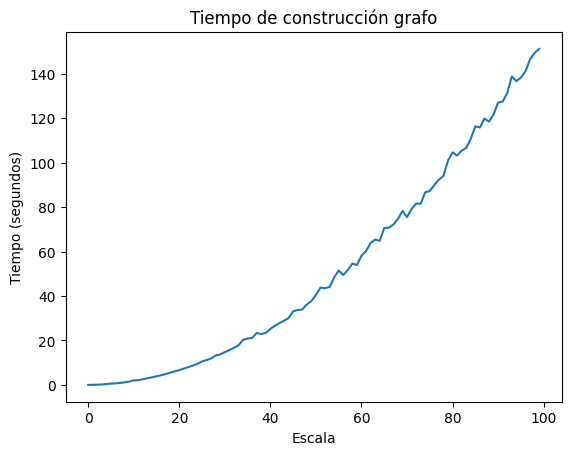

In [17]:
import numpy as np
import matplotlib.pyplot as plt
# Crear un arreglo de 100 valores
# Plotear los valores del arreglo
plt.plot(c2)

# Agregar título y etiquetas
plt.title('Tiempo de construcción grafo')
plt.xlabel('Escala')
plt.ylabel('Tiempo (segundos)')

# Mostrar el gráfico
plt.show()

# ---------------------------------
# Medir tiempos de consultas
# ---------------------------------

larg=100
arboles=[]
for j in range(0,larg):
        arboles.append(estandar_graf(j+1))

In [ ]:
lista_consultar_tramites_en_ministerio=[]
lista_consultar_ministerios=[]
lista_instituciones_asoc_a_ministerio=[]
lista_contar_requisitos_por_ministerio=[] #probar despues a especificar las columnas de la query
lista_requisitos_asoc_a_ministerio=[]
lista_requisitos_distintos=[] #lo mismo que el otro
lista_requisitos_asoc_a_tramite=[]
#--------------------------------------
for j in arboles:
    start_time = time.time()
    for h in consultar_tramites_en_ministerio(j,'A1')[0]:
        0
    end_time = time.time()
    elapsed_time = end_time - start_time    
lista_consultar_tramites_en_ministerio.append(consultar_tramites_en_ministerio(j,'A1')[1]+elapsed_time)
#--------------------------------------
for j in arboles:
    start_time = time.time()
    for h in consultar_ministerios(j,'A1')[0]:
        0
    end_time = time.time()
    elapsed_time = end_time - start_time    
lista_consultar_ministerios.append(consultar_ministerios(j,'A1')[1]+elapsed_time)
#--------------------------------------
for j in arboles:
    start_time = time.time()
    for h in instituciones_asoc_a_ministerio(j,'A1')[0]:
        0
    end_time = time.time()
    elapsed_time = end_time - start_time    
lista_instituciones_asoc_a_ministerio.append(instituciones_asoc_a_ministerio(j,'A1')[1]+elapsed_time)
#--------------------------------------
for j in arboles:
    start_time = time.time()
    for h in contar_requisitos_por_ministerio(j,'A1')[0]:
        0
    end_time = time.time()
    elapsed_time = end_time - start_time    
lista_contar_requisitos_por_ministerio.append(contar_requisitos_por_ministerio(j,'A1')[1]+elapsed_time)
#--------------------------------------
for j in arboles:
    start_time = time.time()
    for h in requisitos_asoc_a_ministerio(j,'A1')[0]:
        0
    end_time = time.time()
    elapsed_time = end_time - start_time    
lista_requisitos_asoc_a_ministerio.append(requisitos_asoc_a_ministerio(j,'A1')[1]+elapsed_time)
#--------------------------------------
for j in arboles:
    start_time = time.time()
    for h in requisitos_distintos(j,'A1')[0]:
        0
    end_time = time.time()
    elapsed_time = end_time - start_time    
lista_requisitos_distintos.append(requisitos_distintos(j,'A1')[1]+elapsed_time)
#--------------------------------------
for j in arboles:
    start_time = time.time()
    for h in requisitos_asoc_a_tramite(j,'A1')[0]:
        0
    end_time = time.time()
    elapsed_time = end_time - start_time    
lista_requisitos_asoc_a_tramite.append(requisitos_asoc_a_tramite(j,'A1')[1]+elapsed_time)
#--------------------------------------

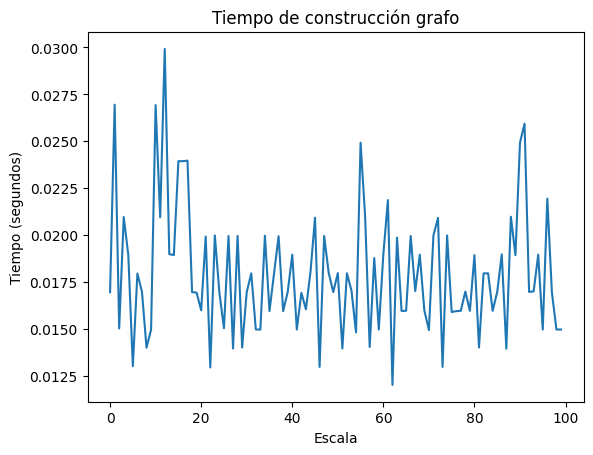

In [34]:
import numpy as np
import matplotlib.pyplot as plt
# Crear un arreglo de 100 valores
# Plotear los valores del arreglo
plt.plot(lista_consultar_tramites_en_ministerio)

# Agregar título y etiquetas
plt.title('Tiempo de construcción grafo')
plt.xlabel('Escala')
plt.ylabel('Tiempo (segundos)')

# Mostrar el gráfico
plt.show()

# ------------------------------------------
## Medir tiempo de inserción de nodos
# ------------------------------------------

In [ ]:
tiempos_insercion=[]
for j in arboles:
    tiempos_insercion.append(agregar_nodo(j,'Institucion'))
    